# Import Packages

In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier

# EDA and Preprocessing

In [2]:
df = pd.read_csv(r'D:\Multi Classification\Home loan Approval\loan_sanction_train.csv')

## Check for statistical description

### Numerical statistical Description

In [3]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


### Categorical Statistical Description

In [4]:
df.describe(include=[object])

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP001002,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


## Distribution Plot Numerical Columns

C:\Users\L580\AppData\Local\Temp\ipykernel_20756\4283695574.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax = ax)


array([[<AxesSubplot:title={'center':'ApplicantIncome'}>,
        <AxesSubplot:title={'center':'CoapplicantIncome'}>],
       [<AxesSubplot:title={'center':'LoanAmount'}>,
        <AxesSubplot:title={'center':'Loan_Amount_Term'}>],
       [<AxesSubplot:title={'center':'Credit_History'}>, <AxesSubplot:>]],
      dtype=object)

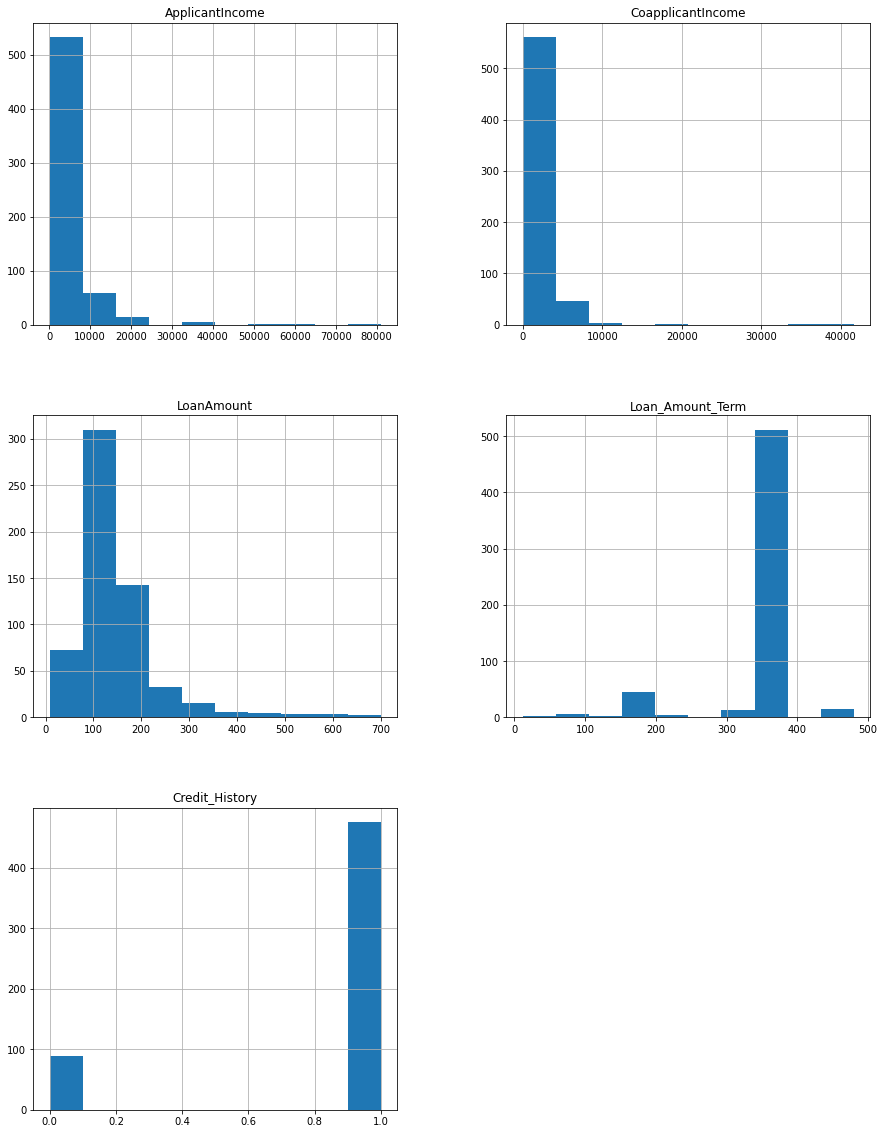

In [5]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df.hist(ax = ax)

## Check for Missing Values

In [6]:
#menghitung missing values
for col in df.columns:
    pct_missing = df[col].isnull().sum()
    print('{} - {}'.format(col,pct_missing))

Loan_ID - 0
Gender - 13
Married - 3
Dependents - 15
Education - 0
Self_Employed - 32
ApplicantIncome - 0
CoapplicantIncome - 0
LoanAmount - 22
Loan_Amount_Term - 14
Credit_History - 50
Property_Area - 0
Loan_Status - 0


In [7]:
#check missing values
df[df.isnull().any(axis=1)]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
11,LP001027,Male,Yes,2,Graduate,NaN,2500,1840.0,109.0,360.0,1.0,Urban,Y
16,LP001034,Male,No,1,Not Graduate,No,3596,0.0,100.0,240.0,NaN,Urban,Y
19,LP001041,Male,Yes,0,Graduate,NaN,2600,3500.0,115.0,NaN,1.0,Urban,Y
23,LP001050,NaN,Yes,2,Not Graduate,No,3365,1917.0,112.0,360.0,0.0,Rural,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,LP002933,NaN,No,3+,Graduate,Yes,9357,0.0,292.0,360.0,1.0,Semiurban,Y
597,LP002943,Male,No,NaN,Graduate,No,2987,0.0,88.0,360.0,0.0,Semiurban,N
600,LP002949,Female,No,3+,Graduate,NaN,416,41667.0,350.0,180.0,NaN,Urban,N
601,LP002950,Male,Yes,0,Not Graduate,NaN,2894,2792.0,155.0,360.0,1.0,Rural,Y


## Replace Missing Values with Mode

### Replace Categorical Missing Values

In [8]:
df['Gender'] = df['Gender'].replace(np.NaN, 'Male')

In [9]:
df.isnull().sum() # Sanity Check

Loan_ID               0
Gender                0
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [10]:
df['Married'] = df['Married'].replace(np.NaN, df['Married'].mode()[0])
df['Dependents'] = df['Dependents'].replace(np.NaN, df.Dependents.mode()[0])
df['Self_Employed'] = df['Self_Employed'].replace(np.NaN, df.Self_Employed.mode()[0])
df['Credit_History'] = df['Credit_History'].replace(np.NaN, df.Credit_History.mode()[0])

##Alternative to replace numerical missing values
#df['LoanAmount'] = df['LoanAmount'].replace(np.NaN, df.LoanAmount.median())
#df['Loan_Amount_Term'] = df['Loan_Amount_Term'].replace(np.NaN, df.Loan_Amount_Term.median())

### Replace Numerical Missing Values with KNN

In [11]:
imputer = KNNImputer(n_neighbors=5)
df_loan_amount = pd.DataFrame(imputer.fit_transform(df.LoanAmount.values.reshape(-1,1)))
df_loan_amount_term = pd.DataFrame(imputer.fit_transform(df.Loan_Amount_Term.values.reshape(-1,1)))

In [12]:
df['LoanAmount'] = df_loan_amount[0]
df['Loan_Amount_Term'] = df_loan_amount_term[0]

In [13]:
df.isnull().sum()# Sanity Check

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

## Standardize Numerical Values

In [14]:
df['ApplicantIncome'] = np.log1p(df['ApplicantIncome']) 
df['CoapplicantIncome'] = np.log1p(df['CoapplicantIncome'])
df['LoanAmount'] = np.log1p(df['LoanAmount'])
df['Loan_Amount_Term'] = np.log1p(df['Loan_Amount_Term'])

## One Hot Key of Categorical Values

In [15]:
# importing one hot encoder 

# creating one hot encoder object 
onehotencoder = OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
df_Gender = pd.DataFrame(onehotencoder.fit_transform(df.Gender.values.reshape(-1,1)).toarray(),
                         columns = ["gender_"+str(int(i)) for i in range(2)])
df_Married = pd.DataFrame(onehotencoder.fit_transform(df.Married.values.reshape(-1,1)).toarray(),
                          columns = ["Married_"+str(int(i)) for i in range(2)])
#df_Dependents = pd.DataFrame(onehotencoder.fit_transform(df.Dependents.values.reshape(-1,1)).toarray(),
#                             columns = ["Dependents_"+str(int(i)) for i in range(4)])
df_Education = pd.DataFrame(onehotencoder.fit_transform(df.Education.values.reshape(-1,1)).toarray(), 
                            columns = ["Education_"+str(int(i)) for i in range(2)])
df_Self_Employed = pd.DataFrame(onehotencoder.fit_transform(df.Self_Employed.values.reshape(-1,1)).toarray(), 
                                columns = ["Self_Employed_"+str(int(i)) for i in range(2)])
df_Credit_History = pd.DataFrame(onehotencoder.fit_transform(df.Credit_History.values.reshape(-1,1)).toarray(), 
                                 columns = ["Credit_History_"+str(int(i)) for i in range(2)])
df_Property_Area = pd.DataFrame(onehotencoder.fit_transform(df.Property_Area.values.reshape(-1,1)).toarray(), 
                                columns = ["Property_Area_"+str(int(i)) for i in range(3)])

In [16]:
df_Married## Sanity Check

,Married_0,Married_1
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0
...,...,...
609,1.0,0.0
610,0.0,1.0
611,0.0,1.0
612,0.0,1.0


## Encoding Features

In [17]:
Target_Encoding = {"Loan_Status":     {"Y": 1, "N": 0}, 
                   "Dependents":     {'0' : 0, '1' : 1, '2' : 1, '3+' : 2}}

In [18]:
df = df.replace(Target_Encoding)
df.Loan_Status

0      1
1      0
2      1
3      1
4      1
      ..
609    1
610    1
611    1
612    1
613    0
Name: Loan_Status, Length: 614, dtype: int64

## Combine and drop features

In [19]:
## Combine all new columns
df = pd.concat([df, 
                df_Gender, 
                df_Married, 
                #df_Dependents, 
                df_Education, 
                df_Self_Employed, 
                df_Credit_History, 
                df_Property_Area], 
               axis=1)

In [20]:
df## sanity check

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,...,Married_1,Education_0,Education_1,Self_Employed_0,Self_Employed_1,Credit_History_0,Credit_History_1,Property_Area_0,Property_Area_1,Property_Area_2
0,LP001002,Male,No,0,Graduate,No,8.674197,0.000000,4.993232,5.888878,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,LP001003,Male,Yes,1,Graduate,No,8.430327,7.319202,4.859812,5.888878,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,LP001005,Male,Yes,0,Graduate,Yes,8.006701,0.000000,4.204693,5.888878,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,LP001006,Male,Yes,0,Not Graduate,No,7.857094,7.765993,4.795791,5.888878,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,LP001008,Male,No,0,Graduate,No,8.699681,0.000000,4.955827,5.888878,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,7.972811,0.000000,4.276666,5.888878,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
610,LP002979,Male,Yes,2,Graduate,No,8.320448,0.000000,3.713572,5.198497,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
611,LP002983,Male,Yes,1,Graduate,No,8.996280,5.484797,5.537334,5.888878,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
612,LP002984,Male,Yes,1,Graduate,No,8.933796,0.000000,5.236442,5.888878,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [21]:
## Clean unnecessary features
df = df.drop(['Loan_ID', 
         'Gender', 
         'Married', 
         #'Dependents', 
         'Education',
         'Self_Employed', 
         'Credit_History',
         'Property_Area'], axis=1)


In [22]:
df ## Sanity Check

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,gender_0,gender_1,Married_0,Married_1,Education_0,Education_1,Self_Employed_0,Self_Employed_1,Credit_History_0,Credit_History_1,Property_Area_0,Property_Area_1,Property_Area_2
0,0,8.674197,0.000000,4.993232,5.888878,1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1,8.430327,7.319202,4.859812,5.888878,0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0,8.006701,0.000000,4.204693,5.888878,1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0,7.857094,7.765993,4.795791,5.888878,1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0,8.699681,0.000000,4.955827,5.888878,1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,7.972811,0.000000,4.276666,5.888878,1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
610,2,8.320448,0.000000,3.713572,5.198497,1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
611,1,8.996280,5.484797,5.537334,5.888878,1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
612,1,8.933796,0.000000,5.236442,5.888878,1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


## Features Correlation

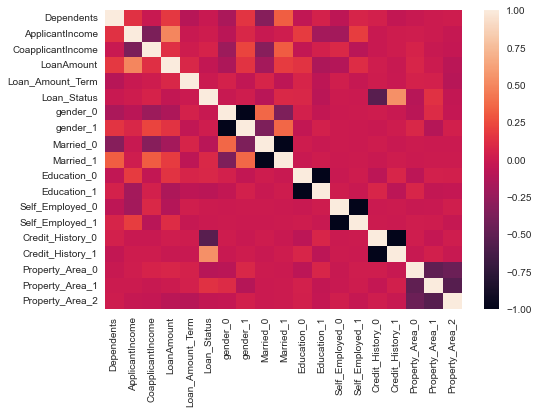

In [69]:
dataplot = sns.heatmap(df.corr())
  
# displaying heatmap
plt.show()

# Classification

## Vanilla with logistic regression

### Split train test

In [23]:
y = df['Loan_Status']
X = df.drop(['Loan_Status'], axis=1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 123)

### Modelling

In [25]:
lr = LogisticRegression(random_state = 42).fit(X_train, y_train)

C:\Users\L580\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Predict and Evaluate

In [26]:
y_pred_lr = lr.predict(X_test)

In [27]:
lr.score(X_test, y_test)

0.772972972972973

In [28]:
confusion_matrix(y_pred_lr,y_test)

array([[ 25,   3],
       [ 39, 118]], dtype=int64)

In [29]:
f1_score(y_pred_lr,y_test)

0.8489208633093525

## Improve with Random Forest and Gridsearch

### Modelling and Gridsearch

In [43]:
rfc = RandomForestClassifier(random_state = 123)

grid_param = {
    'n_estimators' : np.arange(10, 101, 10),
    'max_depth' : np.arange(3, 10),
    'max_features' : np.arange(3, 10)
}

gd_sr = GridSearchCV(rfc, 
                     grid_param,
                     scoring = 'accuracy',
                     cv = 5,
                     n_jobs = -1)

gd_sr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                         'max_features': array([3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
             scoring='accuracy')

### Evaluate and Remodelling

In [44]:
best_parameters = gd_sr.best_params_
print(best_parameters)

{'max_depth': 4, 'max_features': 3, 'n_estimators': 10}


In [45]:
gd_sr.best_score_

0.8274965800273597

In [46]:
rfc = RandomForestClassifier(n_estimators = 40,
                            max_depth = 3,
                            max_features = 3,
                            random_state = 123)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=3, n_estimators=40,
                       random_state=123)

In [47]:
y_pred = rfc.predict(X_test)

In [48]:
accuracy_score(y_pred, y_test)

0.772972972972973

In [49]:
confusion_matrix(y_pred,y_test)

array([[ 25,   3],
       [ 39, 118]], dtype=int64)

In [50]:
f1_score(y_pred,y_test)

0.8489208633093525

## Improve with XGB Classifier and Gridsearch

### Modelling and Gridsearch

In [51]:
XGB = GradientBoostingClassifier(random_state=42)

grid_param_XGB = {
    'n_estimators' : np.arange(10, 101, 10),
    'max_depth' : np.arange(1, 10),
    'max_features' : np.arange(3, 21)
}

gd_sr_XGB = GridSearchCV(XGB, 
                     grid_param_XGB,
                     scoring = 'accuracy',
                     cv = 5,
                     n_jobs = -1)

gd_sr_XGB.fit(X_train, y_train)


C:\Users\L580\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
900 fits failed out of a total of 8100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
900 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\L580\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\L580\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 586, in fit
    n_stages = self._fit_stages(
  File "C:\Users\L580\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 663, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\L580\anaconda3\lib\site-p

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'max_features': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
             scoring='accuracy')

## Evaluate and Remodelling

In [52]:
best_parameters = gd_sr_XGB.best_params_
print(best_parameters)

{'max_depth': 1, 'max_features': 3, 'n_estimators': 20}


In [53]:
gd_sr_XGB.best_score_

0.825143638850889

In [54]:
XGB = RandomForestClassifier(n_estimators = 10,
                            max_depth = 5,
                            max_features = 4,
                            random_state = 123)
XGB.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=4, n_estimators=10,
                       random_state=123)

In [55]:
y_pred = XGB.predict(X_test)

In [56]:
accuracy_score(y_pred, y_test)

0.772972972972973

In [57]:
confusion_matrix(y_pred,y_test)

array([[ 25,   3],
       [ 39, 118]], dtype=int64)

In [58]:
f1_score(y_pred,y_test)

0.8489208633093525

## ROC/AUC Curve

### Predict Model Probability and Determine FPR, TPR

In [59]:
pred_prob1 = lr.predict_proba(X_test)
pred_prob2 = rfc.predict_proba(X_test)
pred_prob3 = XGB.predict_proba(X_test)

In [60]:
from sklearn.metrics import roc_curve
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

### Determine AUC Score

In [61]:
from sklearn.metrics import roc_auc_score
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])
auc_score3 = roc_auc_score(y_test, pred_prob3[:,1])
print(auc_score1, auc_score2, auc_score3 )

0.7793130165289256 0.7961647727272727 0.7806043388429752


### Visualize Curve

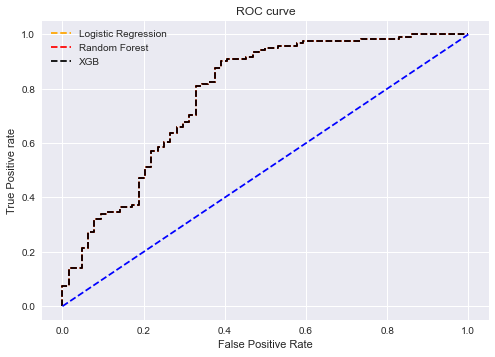

In [63]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--',color='red', label='Random Forest')
plt.plot(fpr3, tpr3, linestyle='--',color='black', label='XGB')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

## Source

https://www.kaggle.com/code/warcoder/100-accuracy-with-random-forest
https://www.kaggle.com/code/danilcherinov/eda-catboost-rf-2
https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
https://pbpython.com/categorical-encoding.html